# quant-econ Solutions: Infinite Horizon Dynamic Programming

Solutions for http://quant-econ.net/jl/lqcontrol.html

Common imports for the exercises

In [1]:
using QuantEcon
using PyPlot

INFO: Loading help data...


## Exercise 1

Here’s one solution

We use some fancy plot commands to get a certain style — feel free to use simpler ones

The model is an LQ permanent income / life-cycle model with hump-shaped income

$$    y_t = m_1 t + m_2 t^2 + \sigma w_{t+1} $$

where $\{w_t\}$ is iid $N(0, 1)$ and the coefficients $m_1$ and $m_2$ are chosen so that
$p(t) = m_1  t + m_2  t^2$ has an inverted U shape with

* $p(0) = 0, p(T/2) = \mu$, and 
* $p(T) = 0$.


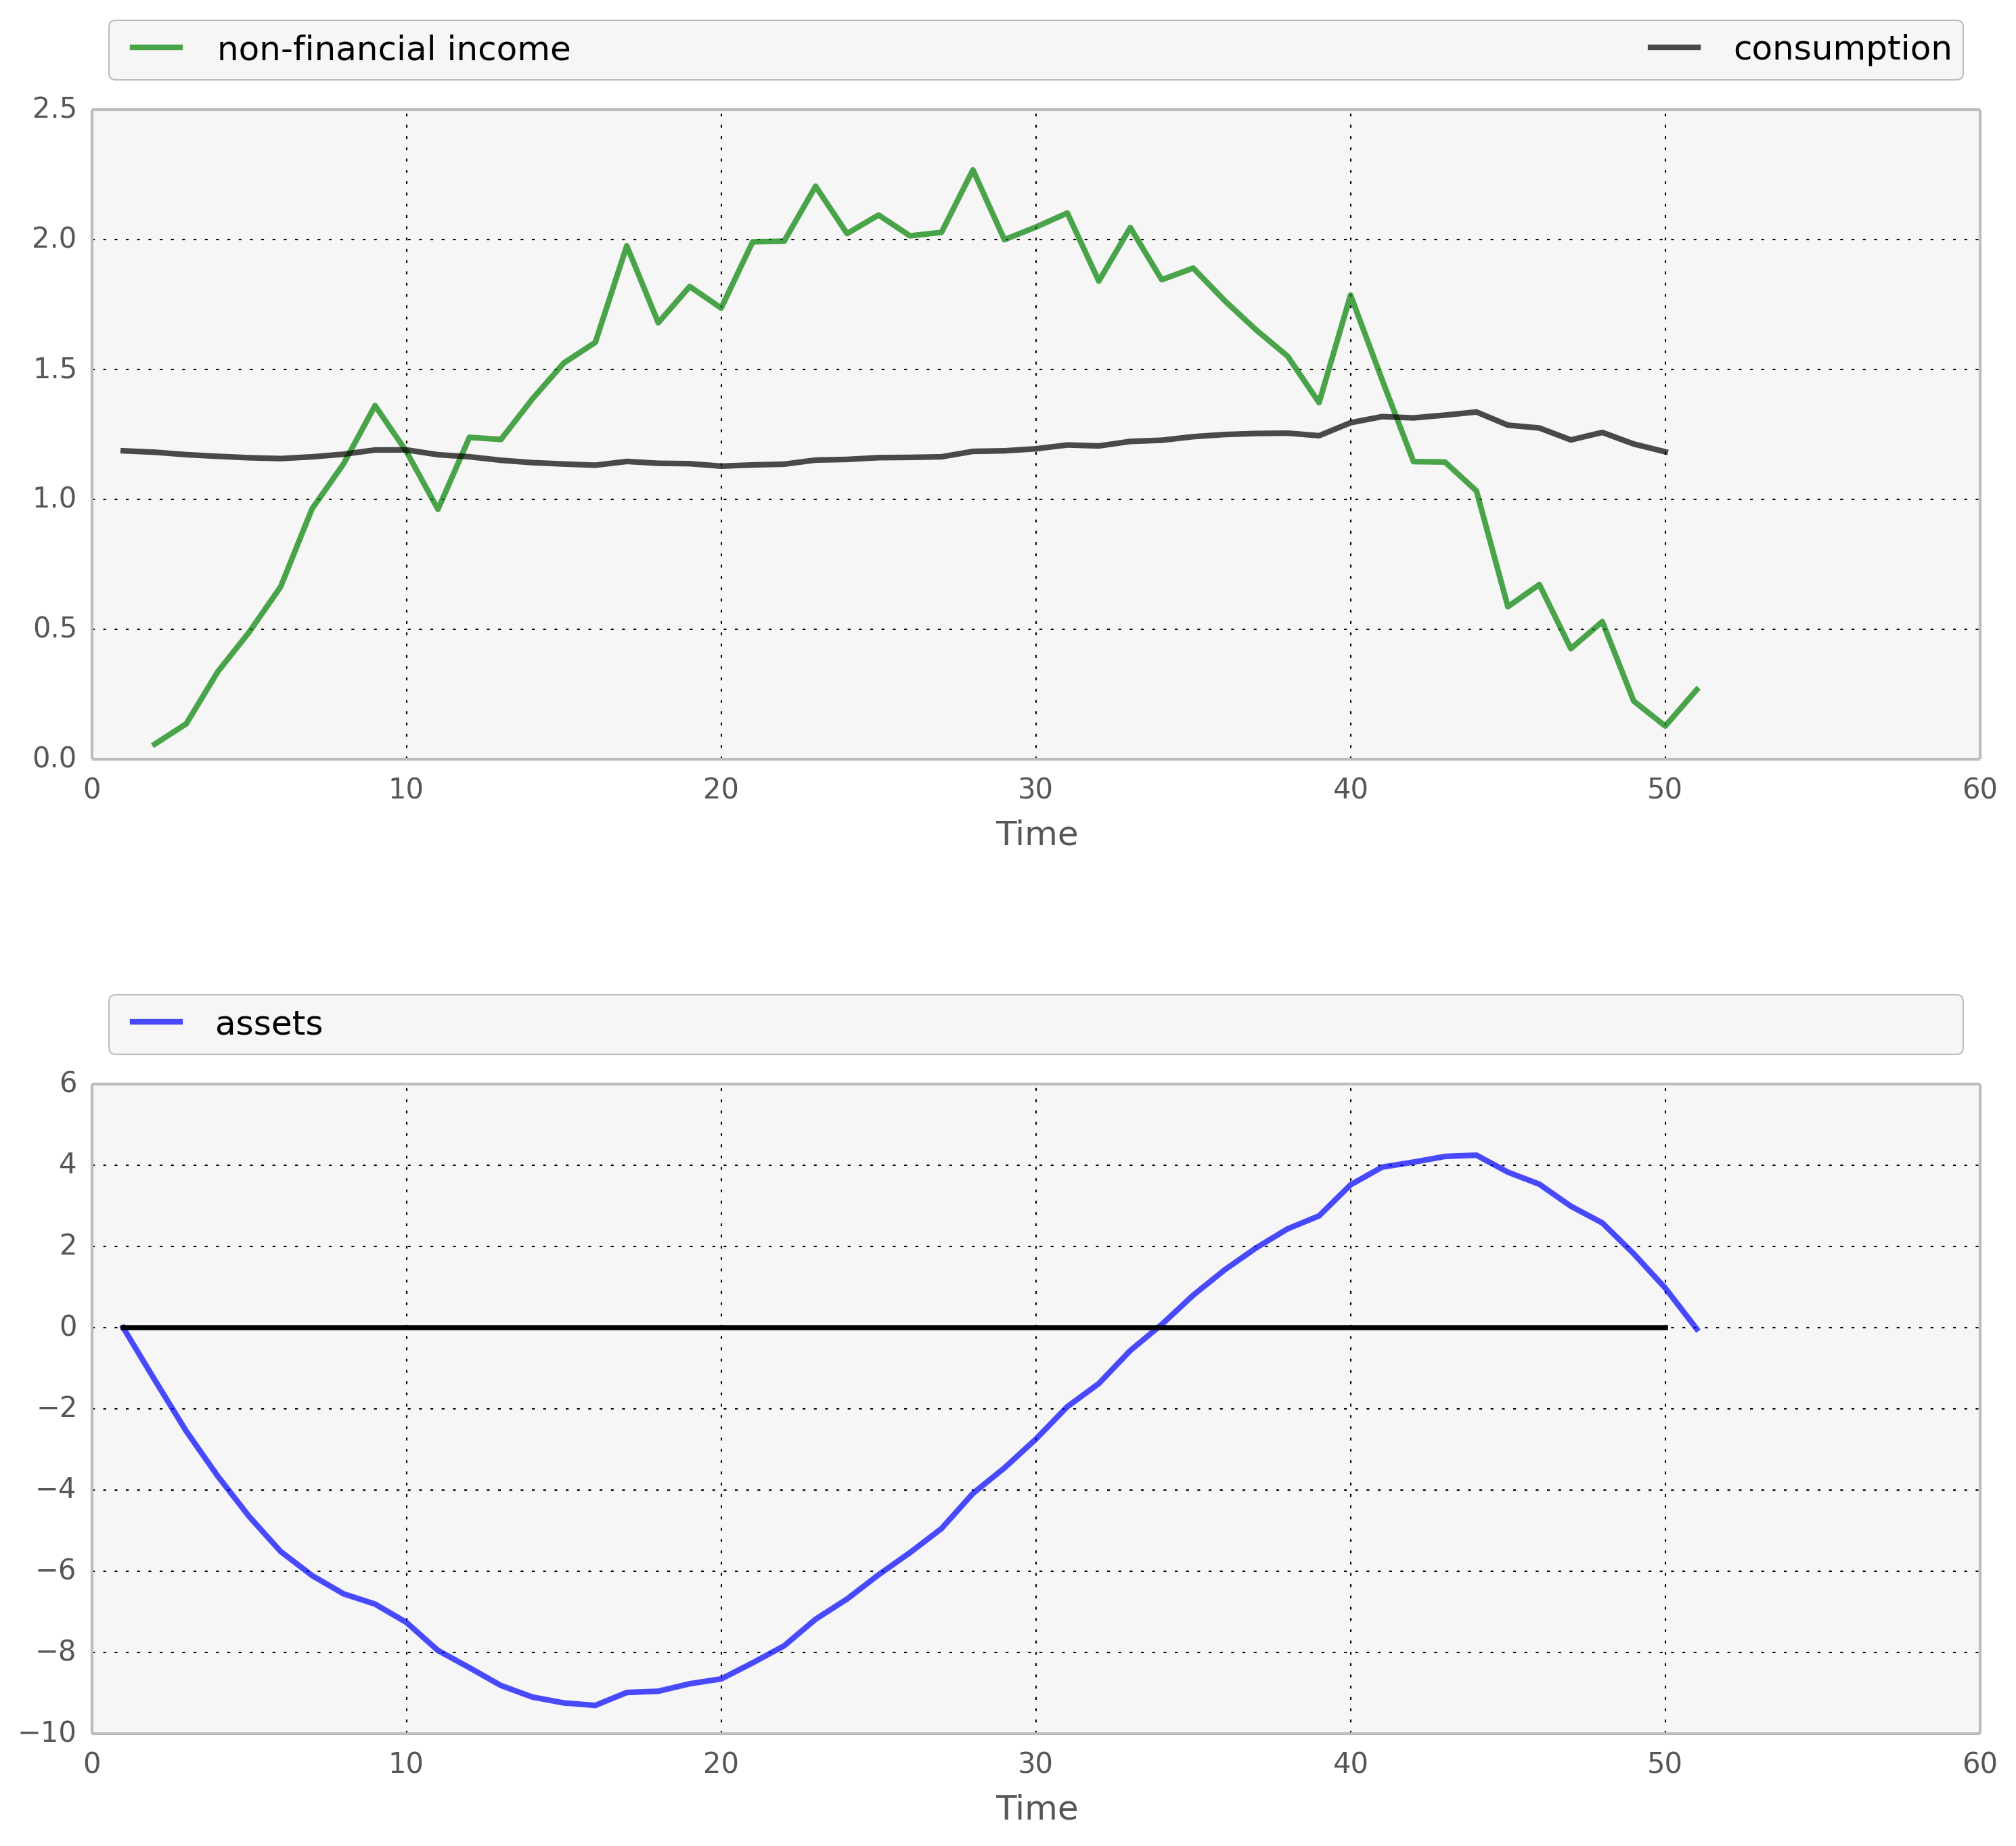

In [3]:
# == Model parameters == #
r       = 0.05
bet     = 1 / (1 + r)
T       = 50
c_bar   = 1.5
sigma   = 0.15
mu      = 2
q       = 1e4
m1      = T * (mu / (T/2)^2)
m2      = - (mu / (T/2)^2)

# == Formulate as an LQ problem == #
Q = 1.0
R = zeros(4, 4)
Rf = zeros(4, 4); Rf[1, 1] = q
A = [1 + r -c_bar m1 m2 
     0     1      0  0
     0     1      1  0
     0     1      2  1]
B = [-1.0, 0.0, 0.0, 0.0]
C = [sigma, 0.0, 0.0, 0.0]

# == Compute solutions and simulate == #
lq = LQ(Q, R, A, B, C, bet, T, Rf)
x0 = Float64[0, 1, 0, 0]
xp, up, wp = compute_sequence(lq, x0)

# == Convert results back to assets, consumption and income == #
ap = squeeze(xp[1, :], 1)               # Assets
c = squeeze(up .+ c_bar, 1)    # Consumption
time = 1:T
income = squeeze(wp[1, 2:end], 1) .+ m1 .* time .+ m2 .* time.^2  # Income

# == Plot results == #
n_rows = 2
fig, axes = subplots(n_rows, 1, figsize=(12, 10))

subplots_adjust(hspace=0.5)
for i=1:n_rows
    axes[i][:grid]()
    axes[i][:set_xlabel]("Time")
end
bbox = [0.0, 1.02, 1.0, 0.102]

axes[1][:plot](2:T+1, income, "g-", label="non-financial income", lw=2, alpha=0.7)
axes[1][:plot](1:T, c, "k-", label="consumption", lw=2, alpha=0.7)
axes[1][:legend](ncol=2, bbox_to_anchor=bbox, loc=3, mode="expand")

axes[2][:plot](1:T+1, ap, "b-", label="assets", lw=2, alpha=0.7)
axes[2][:plot](1:T, zeros(T), "k-")
axes[2][:legend](ncol=1, bbox_to_anchor=bbox, loc=3, mode="expand");

## Exercise 2

This is  a permanent income / life-cycle model with polynomial growth in income
over working life followed by a fixed retirement income.  The model is solved
by combining two LQ programming problems as described in the lecture.

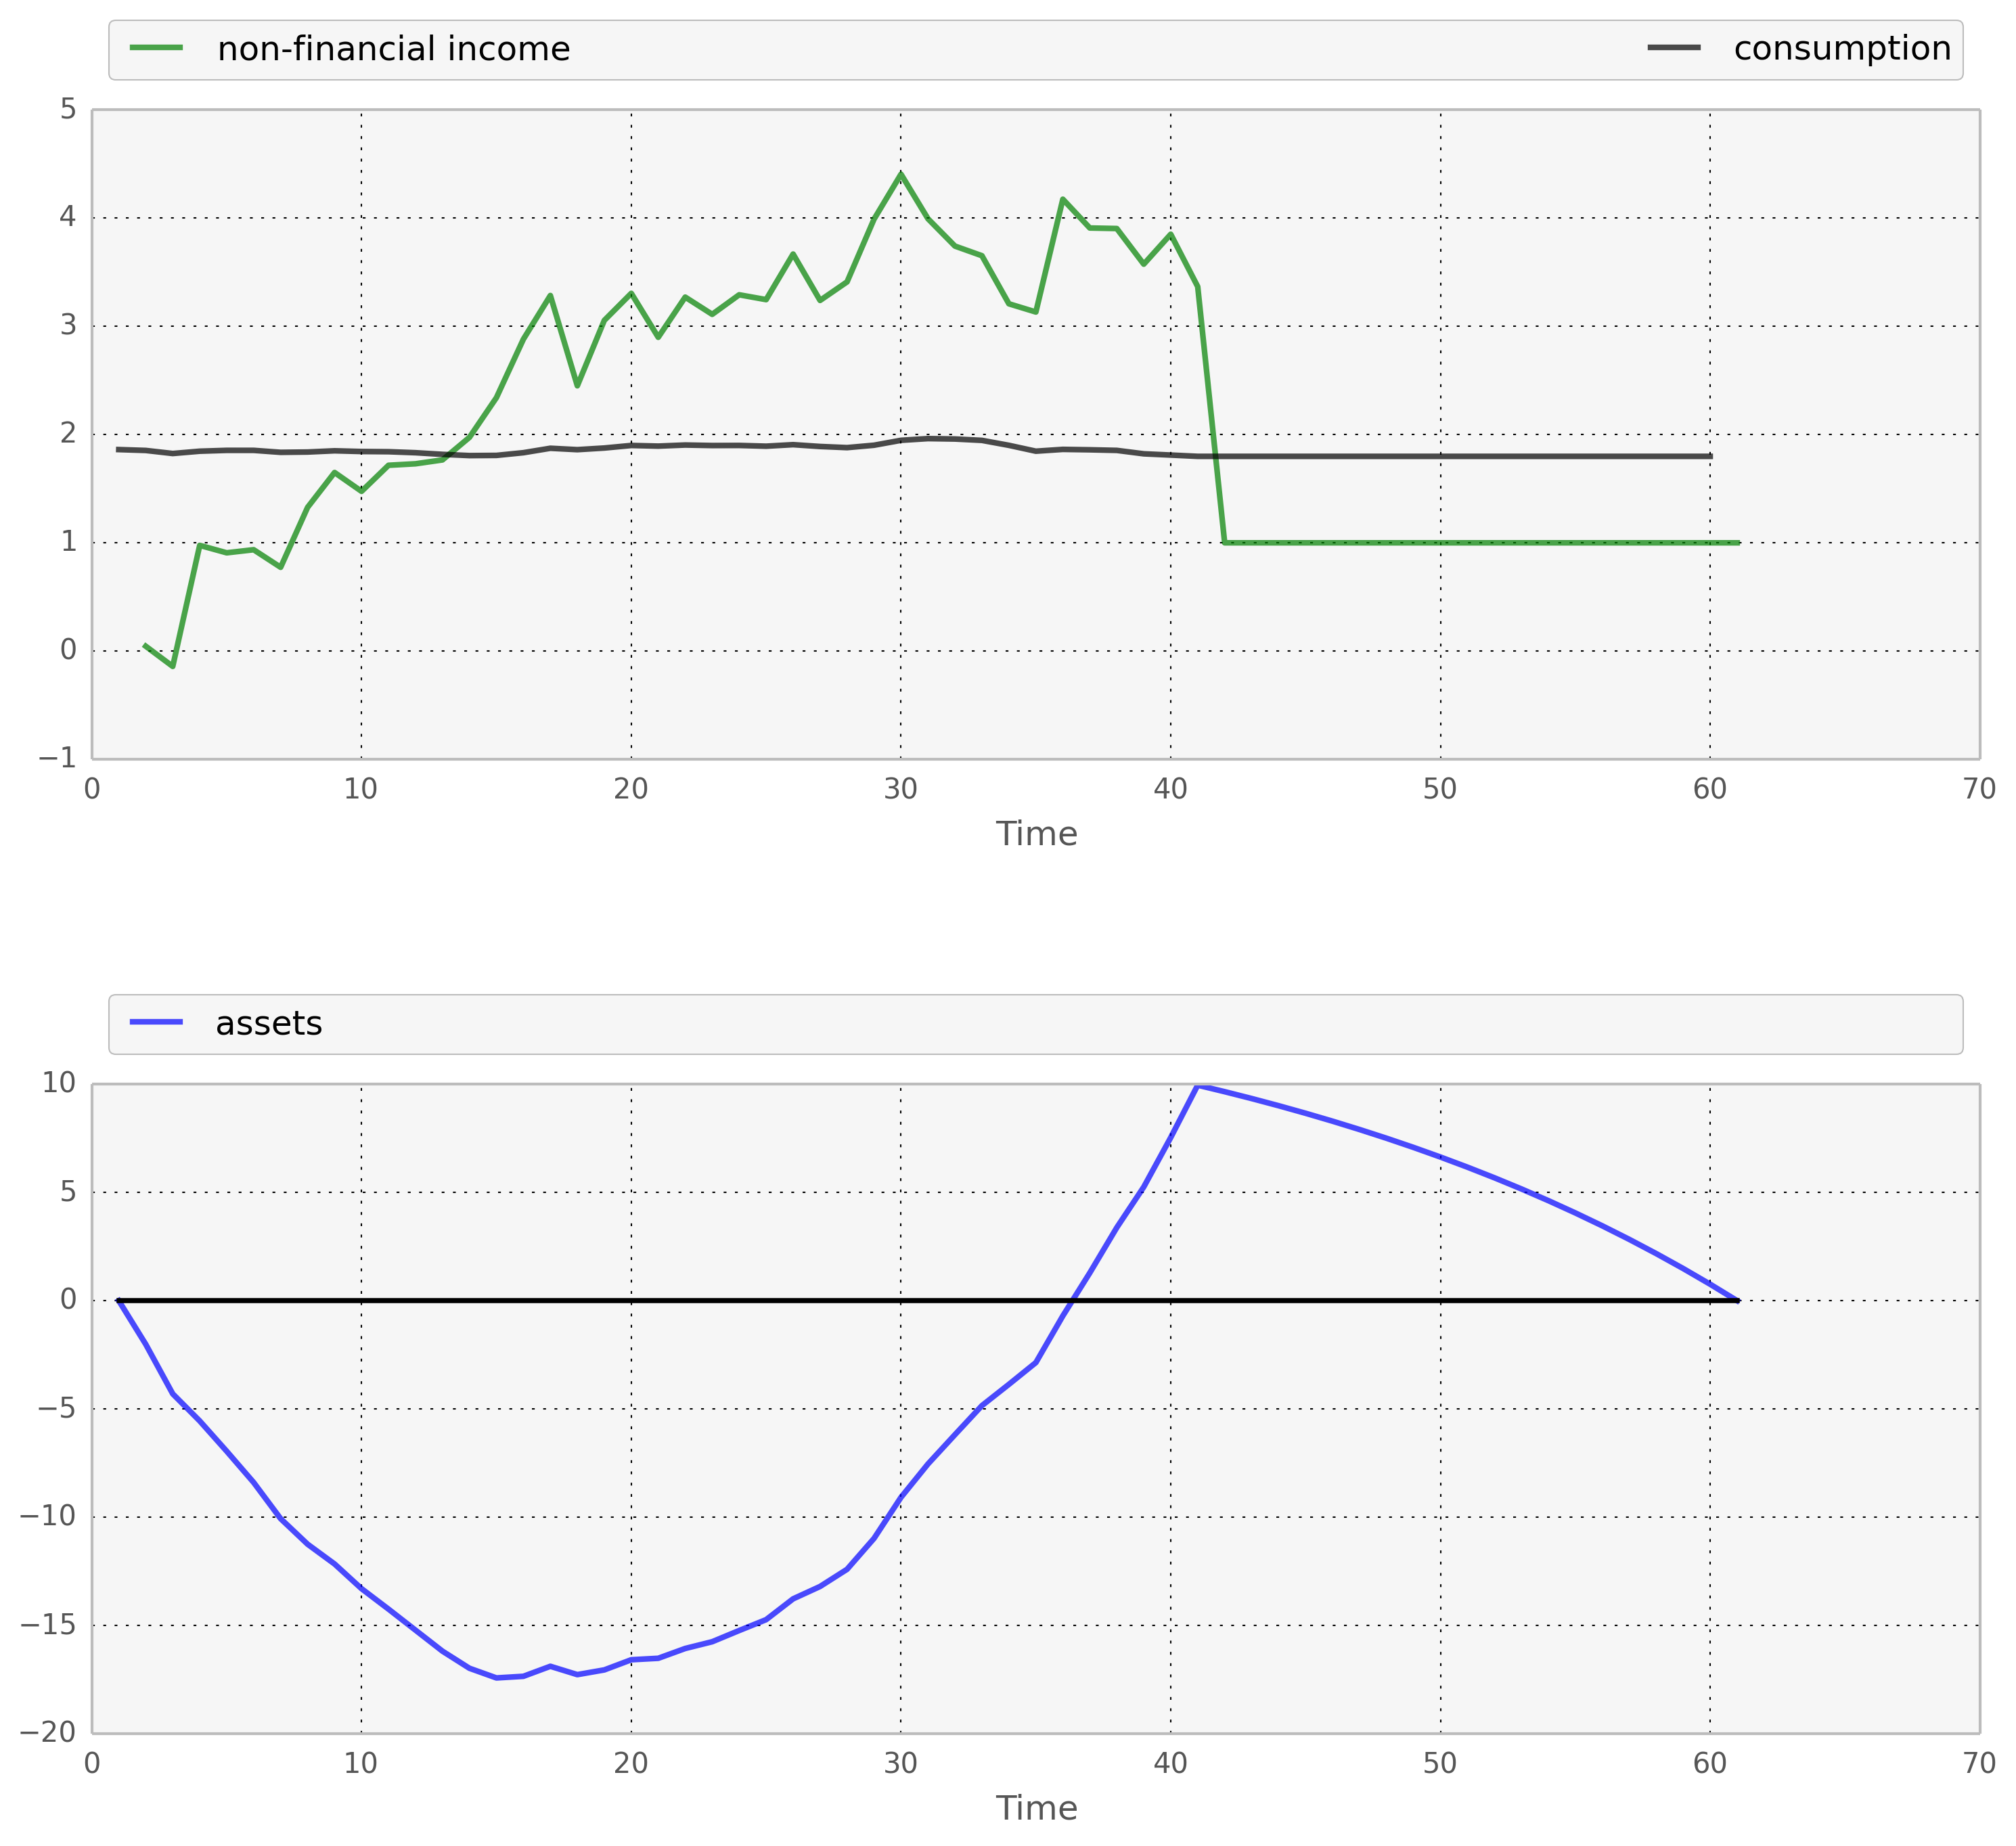

In [4]:
# == Model parameters == #
r       = 0.05
bet     = 1 / (1 + r)
T       = 60
K       = 40
c_bar   = 4
sigma   = 0.35
mu      = 4
q       = 1e4
s       = 1
m1      = 2 * mu / K
m2      = - mu / K^2

# == Formulate LQ problem 1 (retirement) == #
Q = 1.0
R = zeros(4, 4)
Rf = zeros(4, 4); Rf[1, 1] = q
A = [1+r  s-c_bar 0 0 
     0     1      0  0
     0     1      1  0
     0     1      2  1]
B = [-1.0, 0.0, 0.0, 0.0]
C = [0.0, 0.0, 0.0, 0.0]

# == Initialize LQ instance for retired agent == #
lq_retired = LQ(Q, R, A, B, C, bet, T-K, Rf)

# == Iterate back to start of retirement, record final value function == #
for i=1:T-K
    update_values!(lq_retired)
end
Rf2 = lq_retired.P
    
# == Formulate LQ problem 2 (working life) == #
R = zeros(4, 4)
A = [1 + r -c_bar m1 m2 
     0     1      0  0
     0     1      1  0
     0     1      2  1]
B = [-1.0, 0.0, 0.0, 0.0]
C = [sigma, 0.0, 0.0, 0.0]
    
# == Set up working life LQ instance with terminal Rf from lq_retired == #
lq_working = LQ(Q, R, A, B, C, bet, K, Rf2)

# == Simulate working state / control paths == #
    x0 = Float64[0, 1, 0, 0]
xp_w, up_w, wp_w = compute_sequence(lq_working, x0)
# == Simulate retirement paths (note the initial condition) == #
xp_r, up_r, wp_r = compute_sequence(lq_retired, xp_w[:, end]) 

# == Convert results back to assets, consumption and income == #
xp = [xp_w xp_r[:, 2:end]]
assets = squeeze(xp[1, :], 1)               # Assets

up = [up_w up_r]
c = squeeze(up .+ c_bar, 1)    # Consumption

time = 1:K
income_w = squeeze(wp_w[1, 2:K+1], 1) .+ m1 .* time .+ m2 .* time.^2  # Income
income_r = ones(T-K) .* s
income = [income_w, income_r]

# == Plot results == #
n_rows = 2
fig, axes = subplots(n_rows, 1, figsize=(12, 10))

subplots_adjust(hspace=0.5)
for i=1:n_rows
    axes[i][:grid]()
    axes[i][:set_xlabel]("Time")
end
bbox = [0.0, 1.02, 1.0, 0.102]

axes[1][:plot](2:T+1, income, "g-", label="non-financial income", lw=2, alpha=0.7)
axes[1][:plot](1:T, c, "k-", label="consumption", lw=2, alpha=0.7)
axes[1][:legend](ncol=2, bbox_to_anchor=bbox, loc=3, mode="expand")

axes[2][:plot](1:T+1, assets, "b-", label="assets", lw=2, alpha=0.7)
axes[2][:plot](1:T+1, zeros(T+1), "k-")
axes[2][:legend](ncol=2, bbox_to_anchor=bbox, loc=3, mode="expand");

## Exercise 3

The first task is to find the matrices $A, B, C, Q, R$ that define the
LQ problem

Recall that $x_t = (\bar q_t \;\, q_t \;\, 1)'$, while $u_t = q_{t+1} - q_t$

Letting $m_0 := (a_0 - c) / 2a_1$ and $m_1 := 1 / 2 a_1$, we can
write $\bar q_t = m_0 + m_1 d_t$, and then, with some manipulation

$$
    \bar q_{t+1} = m_0 (1 - \rho) + \rho \bar q_t + m_1 \sigma w_{t+1}
$$

By our definition of $u_t$, the dynamics of  $q_t$ are $q_{t+1} = q_t + u_t$

Using these facts you should be able to build the correct $A, B, C$ matrices (and then
check them against those found in the solution code below)

Suitable $R, Q$ matrices can be found by inspecting the objective
function, which we repeat here for convenience:
    
$$
    \min
    \mathbb E \,
    \left\{ 
        \sum_{t=0}^{\infty} \beta^t 
        a_1 ( q_t - \bar q_t)^2 + \gamma u_t^2
    \right\}
$$

Our solution code is


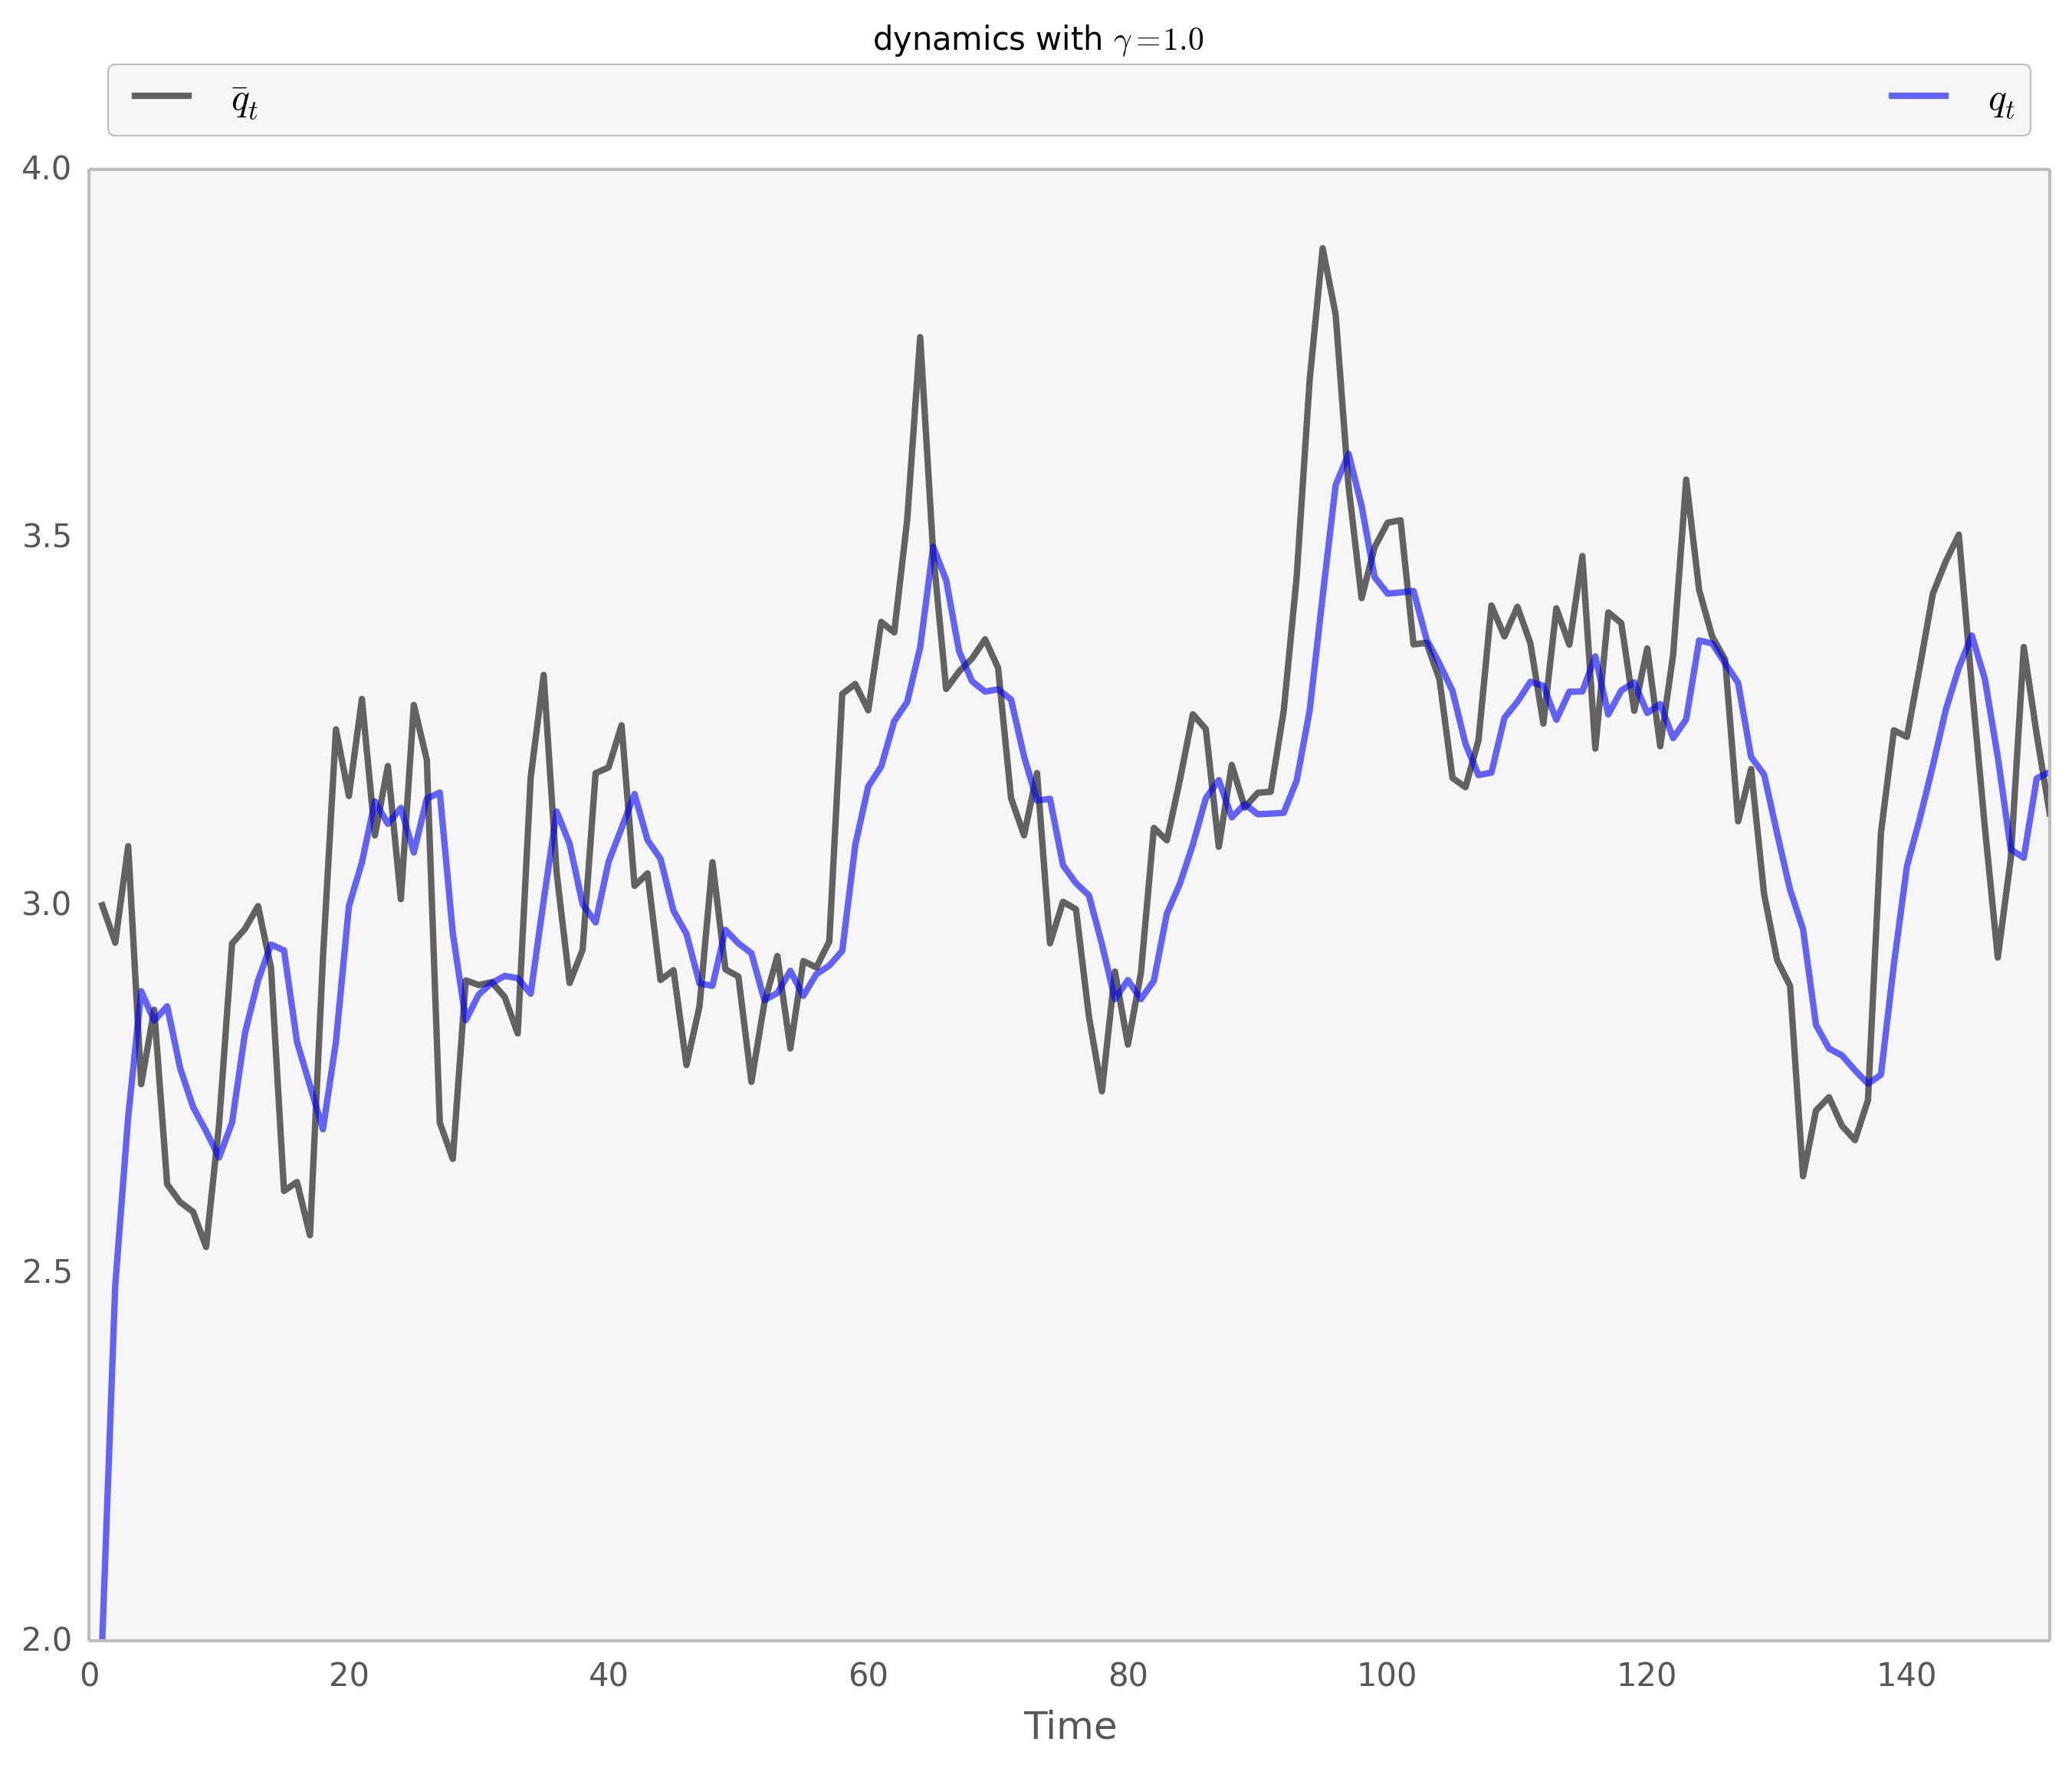

In [5]:
# == Model parameters == #
a0      = 5.0
a1      = 0.5
sigma   = 0.15
rho     = 0.9
gamma   = 1.0
bet     = 0.95
c       = 2.0
T       = 120

# == Useful constants == #
m0 = (a0 - c) / (2 * a1)
m1 = 1 / (2 * a1)

# == Formulate LQ problem == #
Q = gamma
R = [a1 -a1 0
     -a1 a1 0
     0   0  0]
A = [rho 0 m0*(1-rho)
     0   1 0
     0   0 1]

B = [0.0, 1.0, 0.0]
C = [m1 * sigma, 0.0, 0.0]

lq = LQ(Q, R, A, B, C, bet)

# == Simulate state / control paths == #
x0 = [m0, 2.0, 1.0]
xp, up, wp = compute_sequence(lq, x0, 150)
q_bar = squeeze(xp[1, :], 1)
q     = squeeze(xp[2, :], 1)

# == Plot simulation results == #
fig, ax = subplots()
ax[:set_xlabel]("Time")

bbox = [0.0, 1.01, 1.0, 0.101]

time = 1:length(q)
ax[:set_xlim](0, maximum(time))
ax[:plot](time, q_bar, "k-", lw=2, alpha=0.6, label=L"$\bar q_t$")
ax[:plot](time, q, "b-", lw=2, alpha=0.6, label=L"$q_t$")
ax[:legend](ncol=2, bbox_to_anchor=bbox, loc=3, mode="expand")
fig[:suptitle](LaTeXString("dynamics with \$\\gamma =$(gamma)\$"));